# Conformal Estimation for Regression using Mapie

## Estimating prediction intervals of Gamma distributed target

In this example we will use the Mapie Regressor to estimate predictions of intervals associated with gamma distributed target. The limit of the absolute residual conformity score is ilustrated. The data is modelled using a Random Forrest Regressor with a fixed parameter set. The predictions of intervals are determined by mean of the MAPIE regressor considering two conformity score: **Absolute Conformity Score** (which considers the absolute residuals as the conformity scores), **Gamma Score Conformity** (which considers the residuals divided by the predicted mean as conformity scores). We consider the standar cross validation resampling method

In [6]:
import os
import openml
import pandas as pd
import numpy as np

api_key = os.getenv('openmlkey')
openml.config.apikey = api_key 

In [7]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [9]:
datasets_df[datasets_df['name'].str.contains('house')]

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
218,house_8L,1,1,active,ARFF,NaN,NaN,NaN,0.0,9.0,22784.0,0.0,0.0,9.0,0.0
537,houses,1,2,active,ARFF,NaN,NaN,NaN,0.0,9.0,20640.0,0.0,0.0,9.0,0.0
574,house_16H,1,2,active,ARFF,NaN,NaN,NaN,0.0,17.0,22784.0,0.0,0.0,17.0,0.0
821,house_16H,2,2,active,ARFF,16040.0,2.0,6744.0,2.0,17.0,22784.0,0.0,0.0,16.0,1.0
823,houses,2,2,active,ARFF,11726.0,2.0,8914.0,2.0,9.0,20640.0,0.0,0.0,8.0,1.0
843,house_8L,2,2,active,ARFF,16040.0,2.0,6744.0,2.0,9.0,22784.0,0.0,0.0,8.0,1.0
42079,house_sales,1,3422,active,arff,NaN,NaN,NaN,NaN,20.0,21613.0,0.0,0.0,19.0,0.0
42092,house_sales,2,3422,active,arff,NaN,70.0,NaN,0.0,20.0,21613.0,0.0,0.0,18.0,1.0
42165,house_prices,1,3422,active,arff,NaN,NaN,NaN,0.0,81.0,1460.0,1460.0,6965.0,38.0,0.0


In [10]:
dataset = openml.datasets.get_dataset(42165)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'house_prices', the target feature is 'SalePrice'
URL: https://api.openml.org/data/v1/download/21754539/house_prices.arff
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identi


In [11]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from mapie.conformity_scores import GammaConformityScore
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor

np.random.seed(0)

# Parameters
features = [
    "MSSubClass",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "GarageArea",
]
alpha = 0.05
rf_kwargs = {"n_estimators": 10, "random_state": 0}
model = RandomForestRegressor(**rf_kwargs)

In [13]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

<AxesSubplot:>

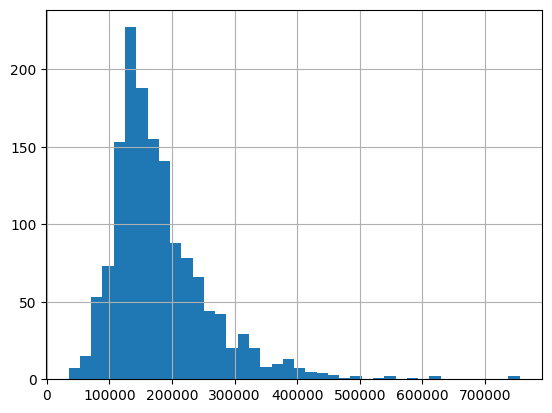

In [18]:
y.hist(bins=40)

### Train model with two conformity scores

Two models are trained with two different conformity score:
- AbsoluteConformityScore: (default conformity score) relevant for target positive as well as negative. The prediction interval widths are, in the case, approximately the same over tha range of prediction.
- GammaConformityScore: Relevant for targe following roughly a Gamma Distribution. The predictions widths scale with the predicted value.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X[features], y, test_size=0.2
)

In [20]:
#Absolute Conformity Score

mapie = MapieRegressor(model)
mapie.fit(X_train, y_train)
y_pred_absconfscore, y_pis_absconfscore = mapie.predict(X_test, alpha=alpha)

coverage_absconfscore = regression_coverage_score(
    y_test, y_pis_absconfscore[:, 0, 0], y_pis_absconfscore[:, 1, 0]
)

Prepare the results for matplotlib. Get the predictions intervals and their corresponding widths. 

In [21]:
def get_yerr(y_pred, y_pis):
    return np.concatenate(
        [
            np.expand_dims(y_pred,0) - y_pis[:,0,0].T,
            y_pis[:,1,0].T - np.expand_dims(y_pred,0)
        ],
        axis = 0
    )

In [22]:
yerr_absconfscore = get_yerr(y_pred_absconfscore, y_pis_absconfscore)
pred_int_width_absconfscore = (
    y_pis_absconfscore[:,1,0] - y_pis_absconfscore[:,0,0]
)

In [23]:
# Gamma Conformity score

mapie = MapieRegressor(model, conformity_score=GammaConformityScore())
mapie.fit(X_train, y_train)
y_pred_gammaconfscore , y_pis_gammaconfscore = mapie.predict(
    X_test, alpha=[alpha]
)

In [24]:
coverage_gammaconfscore = regression_coverage_score(
    y_test, y_pis_gammaconfscore[:,0,0], y_pis_gammaconfscore[:,1,0]
)

yerr_gammaconfscore = get_yerr(y_pred_gammaconfscore, y_pis_gammaconfscore)
pred_int_width_gammaconfscore = (
    y_pis_gammaconfscore[:,1,0] - y_pis_gammaconfscore[:,0,0]
)

### Compare the prediction intervals

Once the models have been trained, we now compare the prediction intervals obtained from the two conformity scores. 

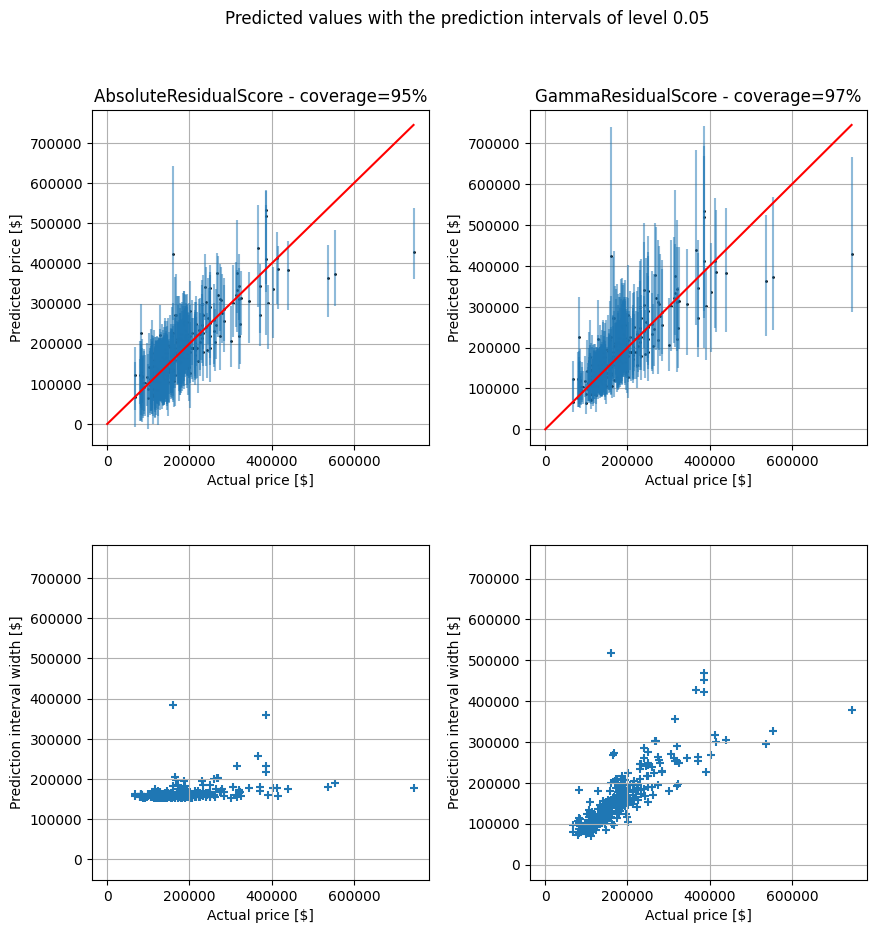

In [25]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

for img_id, y_pred, y_err, cov, class_name, int_width in zip(
    [0,1],
    [y_pred_absconfscore, y_pred_gammaconfscore],
    [yerr_absconfscore, yerr_gammaconfscore],
    [coverage_absconfscore, coverage_gammaconfscore],
    ["AbsoluteResidualScore","GammaResidualScore"],
    [pred_int_width_absconfscore, pred_int_width_gammaconfscore],
):
    axs[0,img_id].errorbar(
        y_test,
        y_pred,
        yerr=y_err,
        alpha=0.5,
        linestyle="None",
    )
    axs[0,img_id].scatter(y_test, y_pred, s=1,color="black")
    axs[0, img_id].plot(
        [0, max(max(y_test), max(y_pred))],
        [0, max(max(y_test), max(y_pred))],
        "-r",
    )
    axs[0, img_id].set_xlabel("Actual price [$]")
    axs[0, img_id].set_ylabel("Predicted price [$]")
    axs[0, img_id].grid()
    axs[0, img_id].set_title(f"{class_name} - coverage={cov:.0%}")

    xmin, xmax = axs[0, img_id].get_xlim()
    ymin, ymax = axs[0, img_id].get_ylim()
    axs[1, img_id].scatter(y_test, int_width, marker="+")
    axs[1, img_id].set_xlabel("Actual price [$]")
    axs[1, img_id].set_ylabel("Prediction interval width [$]")
    axs[1, img_id].grid()
    axs[1, img_id].set_xlim([xmin, xmax])
    axs[1, img_id].set_ylim([ymin, ymax])

fig.suptitle(
    f"Predicted values with the prediction intervals of level {alpha}"
)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## Estimating prediction intervals of time series forecasti with EnbPI

In this case we will use the Victoria electricity demmand dataset used in the book "Forecasting: Principles and Practice" by R.J Hyndman and G.Athanasopoulos. The electricity demand features daily and weekly seasonalities and is impacted by the temperature, considered here as a exogeneous variable.

A random forrest is already fitted on the data. The hyperparameters are already optimized using RandomizedSearchCV using a sequential TimeSeriesSplit cross validation in which the training set is prio to the validation set. 

Then the best model is feeded to the MapieTimeSeriesRegressor, to estimated the associated predictions intervals. We then compare two approaches: with or without *partial_fit*, called at every step following.

In [26]:
from typing import cast

from matplotlib import pylab as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (
    regression_coverage_score,
    regression_mean_width_score,
)
from mapie._typing import NDArray
from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor

# Load input data and feature engineering
url_file = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/"
    + "master/examples/data/demand_temperature.csv"
)
demand_df = pd.read_csv(url_file, parse_dates=True, index_col=0)

In [27]:
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)

demand_df

,Demand,Temperature,Date,Weekofyear,Weekday,Hour,Lag_1,Lag_2,Lag_3,Lag_4
2014-01-01 00:00:00,3.794,18.05,2014-01-01 00:00:00,1,3,0,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,3.418,17.20,2014-01-01 01:00:00,1,3,1,3.794,NaN,NaN,NaN
2014-01-01 02:00:00,3.152,16.45,2014-01-01 02:00:00,1,3,2,3.418,3.794,NaN,NaN
2014-01-01 03:00:00,3.026,16.65,2014-01-01 03:00:00,1,3,3,3.152,3.418,3.794,NaN
2014-01-01 04:00:00,3.022,16.40,2014-01-01 04:00:00,1,3,4,3.026,3.152,3.418,3.794
...,...,...,...,...,...,...,...,...,...,...
2014-02-25 19:00:00,4.968,20.10,2014-02-25 19:00:00,9,2,19,5.066,5.455,5.957,6.226
2014-02-25 20:00:00,4.742,19.90,2014-02-25 20:00:00,9,2,20,4.968,5.066,5.455,5.957
2014-02-25 21:00:00,4.304,19.30,2014-02-25 21:00:00,9,2,21,4.742,4.968,5.066,5.455
2014-02-25 22:00:00,4.105,19.05,2014-02-25 22:00:00,9,2,22,4.304,4.742,4.968,5.066


In [28]:
# Train/validation/test split
num_test_steps = 24 * 7

demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"] + [
    f"Lag_{hour}" for hour in range(1, n_lags)
]

In [29]:
X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
X_train

,Weekofyear,Weekday,Hour,Temperature,Lag_1,Lag_2,Lag_3,Lag_4
2014-01-01 04:00:00,1,3,4,16.40,3.026,3.152,3.418,3.794
2014-01-01 05:00:00,1,3,5,17.95,3.022,3.026,3.152,3.418
2014-01-01 06:00:00,1,3,6,19.70,3.055,3.022,3.026,3.152
2014-01-01 07:00:00,1,3,7,20.60,3.180,3.055,3.022,3.026
2014-01-01 08:00:00,1,3,8,22.35,3.276,3.180,3.055,3.022
...,...,...,...,...,...,...,...,...
2014-02-18 19:00:00,8,2,19,23.55,5.507,5.838,6.097,6.048
2014-02-18 20:00:00,8,2,20,21.90,5.267,5.507,5.838,6.097
2014-02-18 21:00:00,8,2,21,20.75,5.003,5.267,5.507,5.838
2014-02-18 22:00:00,8,2,22,20.15,4.462,5.003,5.267,5.507


In [30]:
y_train = demand_train.loc[X_train.index, "Demand"]
X_test = demand_test.loc[:, features]
y_test = demand_test["Demand"]

In [31]:
perform_hyperparameters_search = True
if perform_hyperparameters_search:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59
    )


In [32]:
# Estimate prediction intervals on test set with best estimator
alpha = 0.05
cv_mapietimeseries = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)

mapie_enpbi = MapieTimeSeriesRegressor(
    model,
    method="enbpi",
    cv=cv_mapietimeseries,
    agg_function="mean",
    n_jobs=-1,
)

In [33]:
print("EnbPI, with no partial_fit, width optimization")
mapie_enpbi = mapie_enpbi.fit(X_train, y_train)
y_pred_npfit_enbpi, y_pis_npfit_enbpi = mapie_enpbi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit_enbpi = regression_coverage_score(
    y_test, y_pis_npfit_enbpi[:, 0, 0], y_pis_npfit_enbpi[:, 1, 0]
)

width_npfit_enbpi = regression_mean_width_score(
    y_pis_npfit_enbpi[:, 1, 0], y_pis_npfit_enbpi[:, 0, 0]
)

EnbPI, with no partial_fit, width optimization


In [34]:
print("EnbPI with partial_fit, width optimization")
mapie_enpbi = mapie_enpbi.fit(X_train, y_train)
y_pred_pfit_enbpi = np.zeros(y_pred_npfit_enbpi.shape)
y_pis_pfit_enbpi = np.zeros(y_pis_npfit_enbpi.shape)

step_size = 1
(
    y_pred_pfit_enbpi[:step_size],
    y_pis_pfit_enbpi[:step_size, :, :],
) = mapie_enpbi.predict(
    X_test.iloc[:step_size, :], alpha=alpha, ensemble=True, optimize_beta=True
)

for step in range(step_size, len(X_test), step_size):
    mapie_enpbi.partial_fit(
        X_test.iloc[(step - step_size):step, :],
        y_test.iloc[(step - step_size):step],
    )
    (
        y_pred_pfit_enbpi[step:step + step_size],
        y_pis_pfit_enbpi[step:step + step_size, :, :],
    ) = mapie_enpbi.predict(
        X_test.iloc[step:(step + step_size), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
    )
coverage_pfit_enbpi = regression_coverage_score(
    y_test, y_pis_pfit_enbpi[:, 0, 0], y_pis_pfit_enbpi[:, 1, 0]
)
width_pfit_enbpi = regression_mean_width_score(
    y_pis_pfit_enbpi[:, 1, 0], y_pis_pfit_enbpi[:, 0, 0]
)

EnbPI with partial_fit, width optimization


In [35]:
# Print results
print(
    "Coverage / prediction interval width mean for MapieTimeSeriesRegressor: "
    "\nEnbPI without any partial_fit:"
    f"{coverage_npfit_enbpi :.3f}, {width_npfit_enbpi:.3f}"
)
print(
    "Coverage / prediction interval width mean for MapieTimeSeriesRegressor: "
    "\nEnbPI with partial_fit:"
    f"{coverage_pfit_enbpi:.3f}, {width_pfit_enbpi:.3f}"
)

enbpi_no_pfit = {
    "y_pred": y_pred_npfit_enbpi,
    "y_pis": y_pis_npfit_enbpi,
    "coverage": coverage_npfit_enbpi,
    "width": width_npfit_enbpi,
}

enbpi_pfit = {
    "y_pred": y_pred_pfit_enbpi,
    "y_pis": y_pis_pfit_enbpi,
    "coverage": coverage_pfit_enbpi,
    "width": width_pfit_enbpi,
}

results = [enbpi_no_pfit, enbpi_pfit]

Coverage / prediction interval width mean for MapieTimeSeriesRegressor: 
EnbPI without any partial_fit:0.911, 0.294
Coverage / prediction interval width mean for MapieTimeSeriesRegressor: 
EnbPI with partial_fit:0.905, 0.291


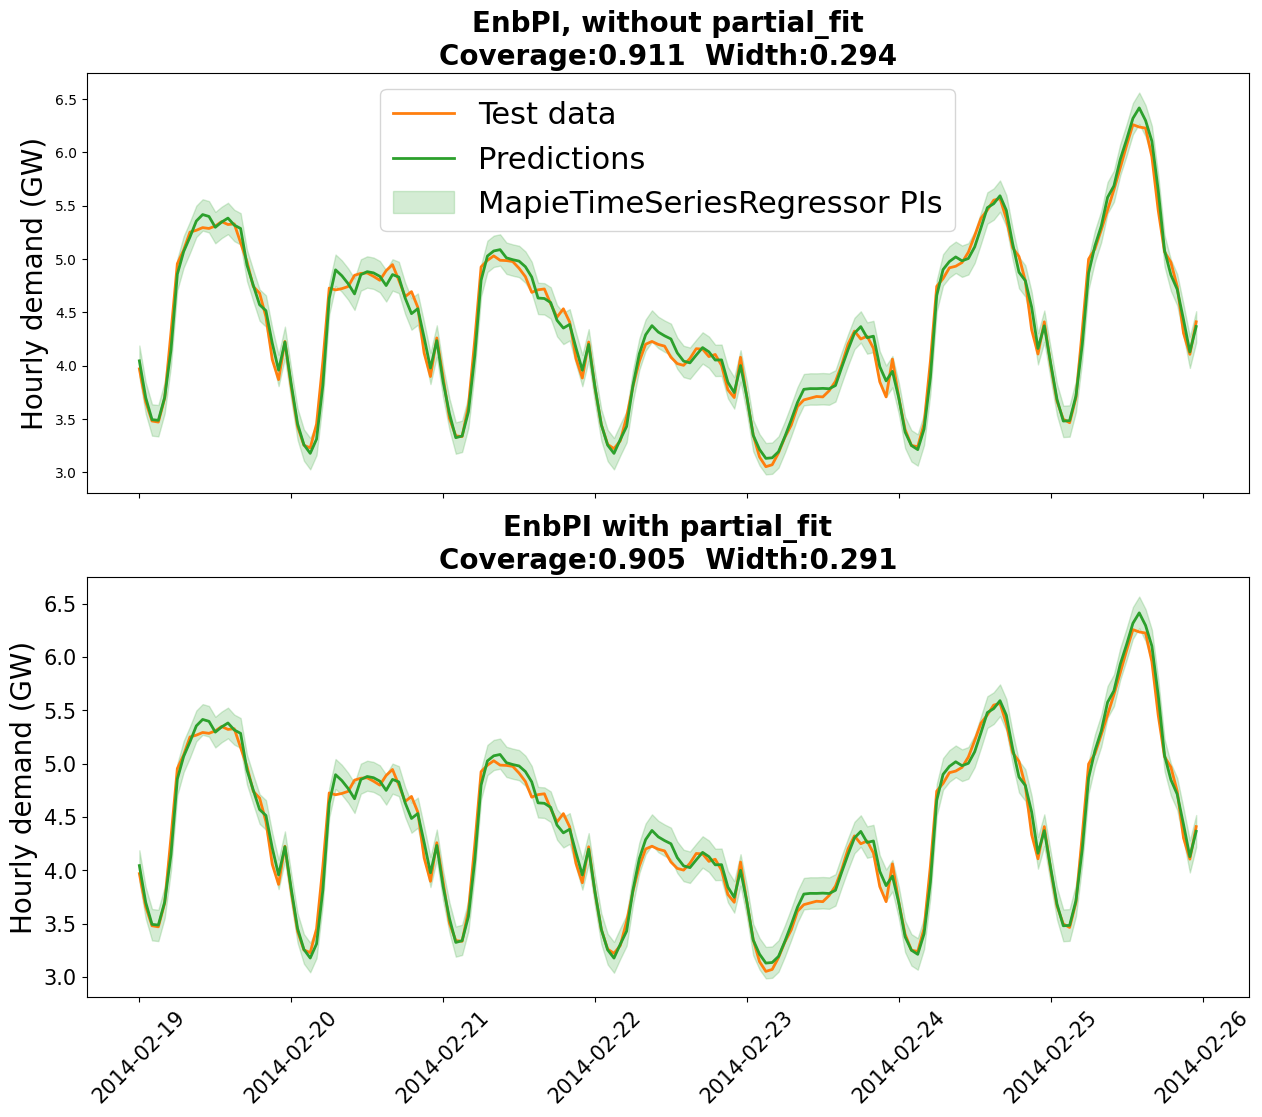

In [36]:
# Plot estimated prediction intervals on test set
fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(15, 12), sharex="col"
)

for i, (ax, w, result) in enumerate(
    zip(axs, ["EnbPI, without partial_fit", "EnbPI with partial_fit"], results)
):
    ax.set_ylabel("Hourly demand (GW)", fontsize=20)
    ax.plot(demand_test.Demand, lw=2, label="Test data", c="C1")

    ax.plot(
        demand_test.index,
        result["y_pred"],
        lw=2,
        c="C2",
        label="Predictions",
    )

    y_pis = cast(NDArray, result["y_pis"])

    ax.fill_between(
        demand_test.index,
        y_pis[:, 0, 0],
        y_pis[:, 1, 0],
        color="C2",
        alpha=0.2,
        label="MapieTimeSeriesRegressor PIs",
    )

    ax.set_title(
        w + "\n"
        f"Coverage:{result['coverage']:.3f}  Width:{result['width']:.3f}",
        fontweight="bold",
        size=20
    )
    plt.xticks(size=15, rotation=45)
    plt.yticks(size=15)

axs[0].legend(prop={'size': 22})
plt.show()